In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing


In [3]:
device = 'cpu'

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

In [6]:
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [7]:
trainset = DataLoader(trainset, batch_size=32, shuffle=True)
testset = DataLoader(testset, batch_size=32, shuffle=False)

In [18]:
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16,
                           kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,
                           stride=1, padding=1)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,
                           stride=1, padding=1)
    self.fcl1 = nn.Linear(64*5*5, 128)
    self.fcl2 = nn.Linear(128, 64)
    self.fcl3 = nn.Linear(64, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x)
    x = x.reshape(x.shape[0], -1)
    x = F.relu(self.fcl1(x))
    x = F.relu(self.fcl2(x))
    x = F.relu(self.fcl3(x))
    return x


In [9]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [10]:
def train_one_epoch(train_data, model, opt, loss_fn):
  train_acc, train_loss = [], []
  for i, data in enumerate(train_data):
    X, y = data
    X, y = X.to(device), y.to(device)

    opt.zero_grad()
    y_logits = model(X).squeeze()
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y)
    acc = accuracy_fn(y, y_pred)
    loss.backward()
    opt.step()
    train_acc.append(acc)
    train_loss.append(loss.item())
  return train_acc, train_loss

In [11]:
from sklearn.metrics import confusion_matrix

def predict_one_epoch(test_data, model, loss_fn):
  preds, labels = [], []
  test_acc, test_loss = [], []
  for i, data in enumerate(test_data):
    X_test, y_test = data
    X_test, y_test = X_test.to(device), y_test.to(device)
    y_logits = model(X_test).squeeze()
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_test)
    acc = accuracy_fn(y_test, y_pred)
    labels.extend(y_test.cpu().numpy())
    preds.extend(y_pred.cpu().numpy())
    test_acc.append(acc)
    test_loss.append(loss.item())
  cm = confusion_matrix(labels, preds)
  return preds, test_acc, test_loss, cm

In [12]:
def plotting_metrics(epochs, train_metric, test_metric, type='loss'):
  plt.plot([i for i in range(0, epochs)], train_metric, label=f"Train {type}")
  plt.plot([i for i in range(0, epochs)], test_metric, label=f"Test {type}")
  plt.title(f"Training and test {type} curves")
  plt.ylabel(f"{type}")
  plt.xlabel("Epochs")
  plt.legend()
  plt.show()

In [13]:
torch.manual_seed(42)

def pipeline(model, loos_fn, opt, epochs):
  total_train_loss, total_train_acc = [], []
  total_test_loos, total_test_acc = [], []
  for epoch in range(1, epochs+1):
    running_loss = 0
    model.train()
    train_acc, train_loss = train_one_epoch(trainset, model, opt, loss_fn)
    train_loss = np.mean(train_loss)
    train_acc = np.mean(train_acc)
    total_train_loss.append(train_loss)
    total_train_acc.append(train_acc)
    model.eval()
    with torch.inference_mode():
      test_preds, test_acc, test_loss, cm = predict_one_epoch(testset, model, loss_fn)
      test_acc = np.mean(test_acc)
      test_loss = np.mean(test_loss)
      total_test_loos.append(test_loss)
      total_test_acc.append(test_acc)
      if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
      if epoch == (epochs - 1):
        print('Test confusion matrix\n', cm)
  plotting_metrics(epochs, total_train_loss, total_test_loos, 'loss')
  plotting_metrics(epochs, total_train_acc, total_test_acc, 'accuracy')

  return test_preds


Epoch: 10 | Loss: 0.05173, Acc: 98.39% | Test Loss: 0.03983, Test Acc: 98.69%
Epoch: 20 | Loss: 0.02352, Acc: 99.25% | Test Loss: 0.03670, Test Acc: 98.79%
Test confusion matrix
 [[ 976    0    0    0    0    2    1    0    0    1]
 [   1 1130    1    1    0    0    1    0    1    0]
 [   2    0 1026    2    0    0    0    2    0    0]
 [   1    0    0 1007    0    2    0    0    0    0]
 [   0    0    1    0  975    0    1    3    1    1]
 [   2    0    0   10    0  879    1    0    0    0]
 [   8    2    0    1    0    8  939    0    0    0]
 [   0    2    5    2    0    0    0 1016    1    2]
 [   5    0    5   30    0   12    2    2  914    4]
 [   0    4    0   14   10    2    0    5    0  974]]
Epoch: 30 | Loss: 0.01184, Acc: 99.65% | Test Loss: 0.03504, Test Acc: 98.93%


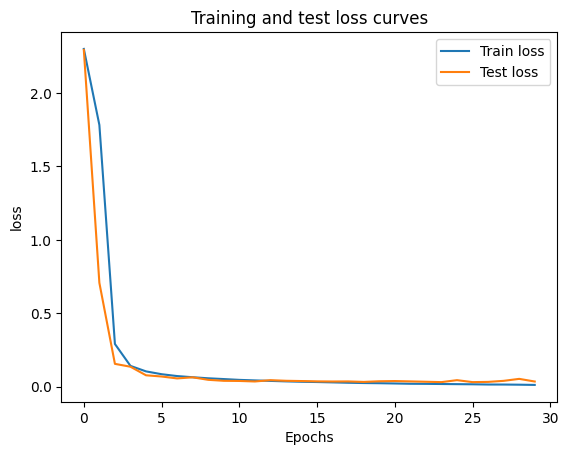

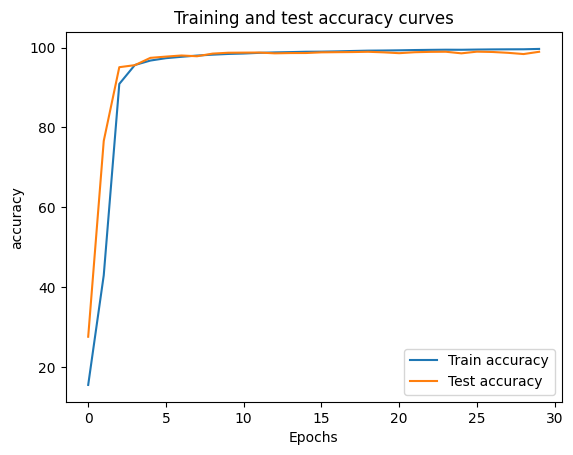

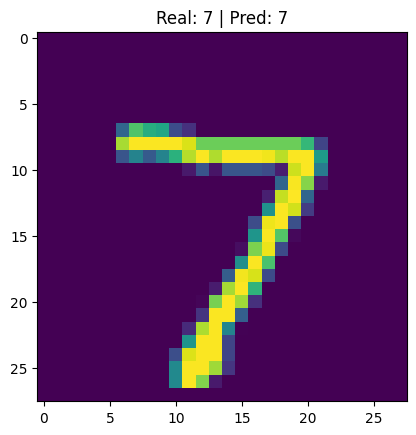

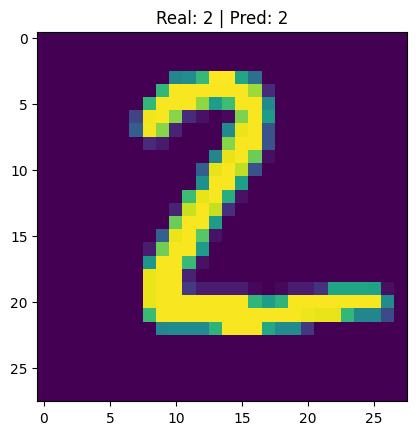

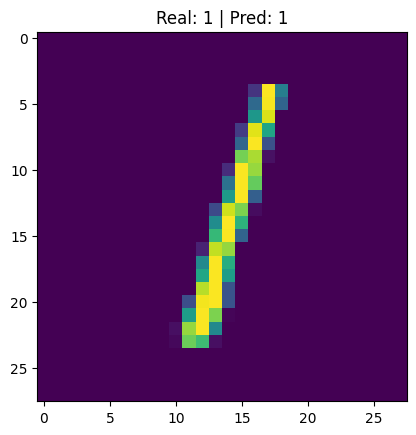

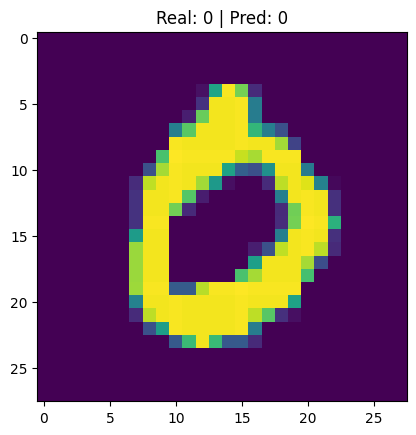

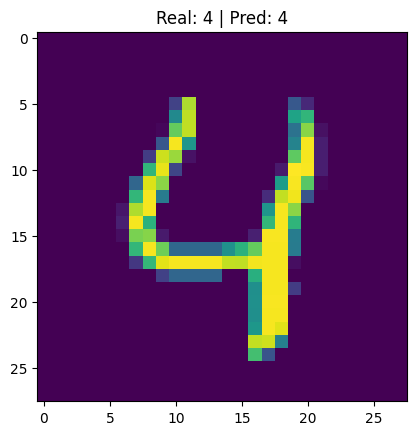

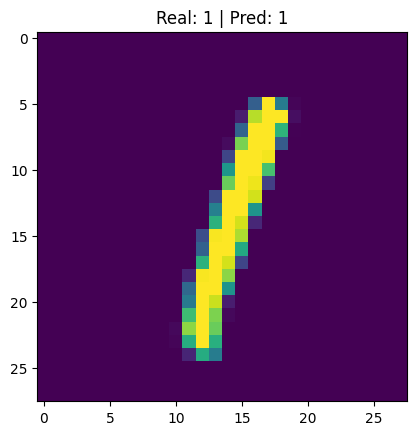

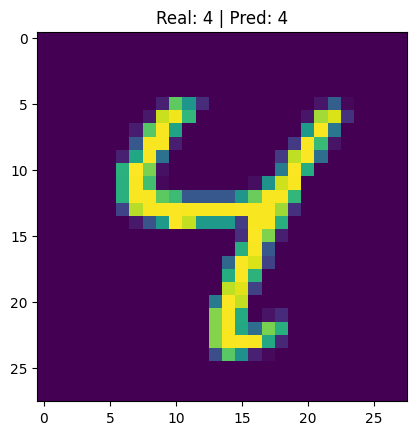

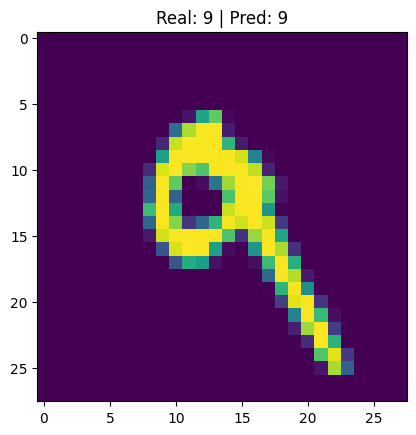

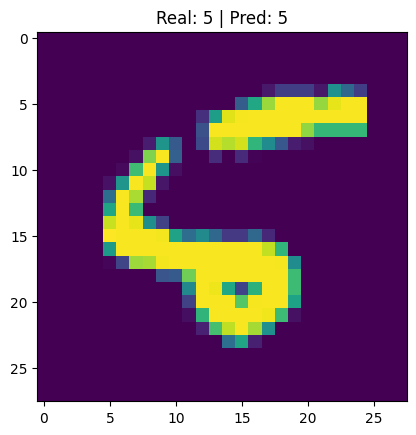

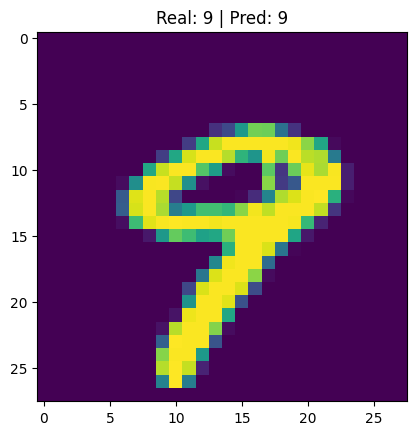

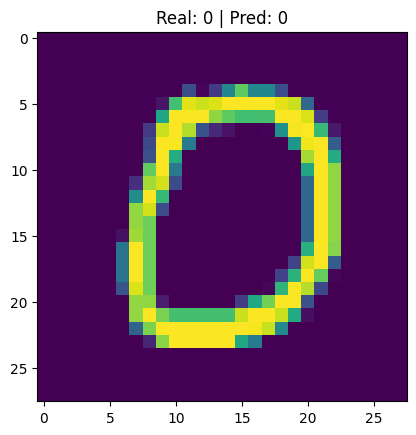

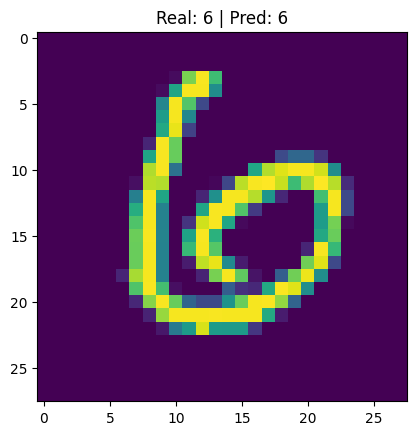

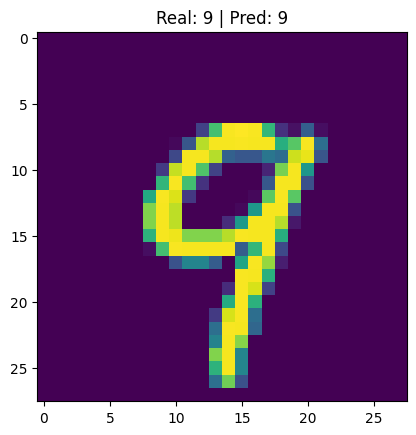

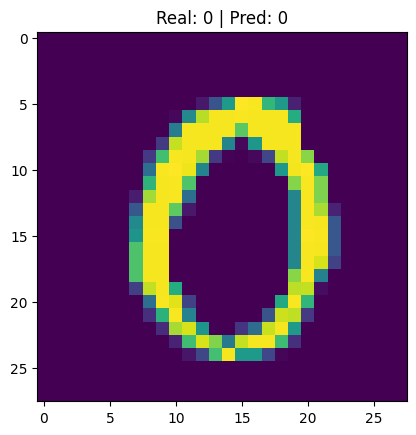

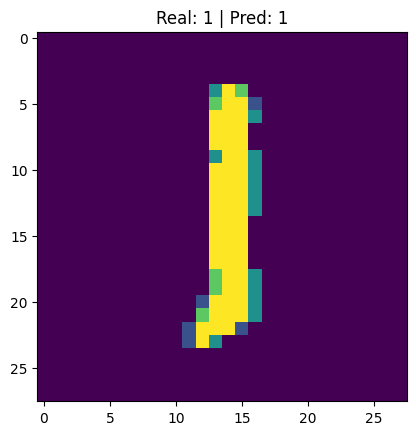

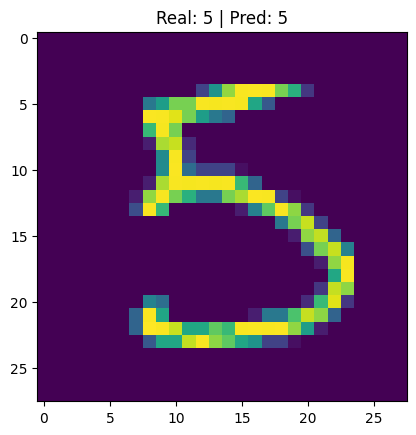

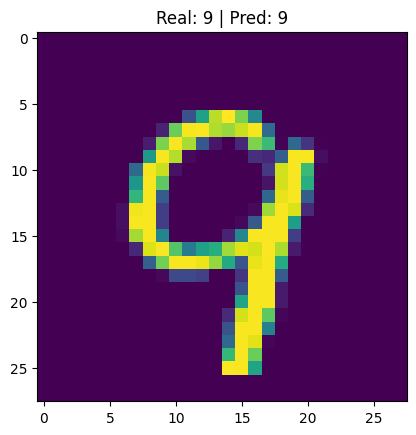

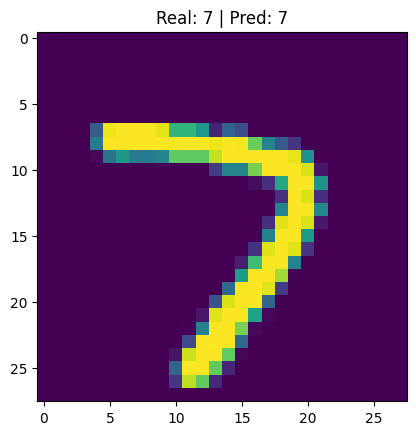

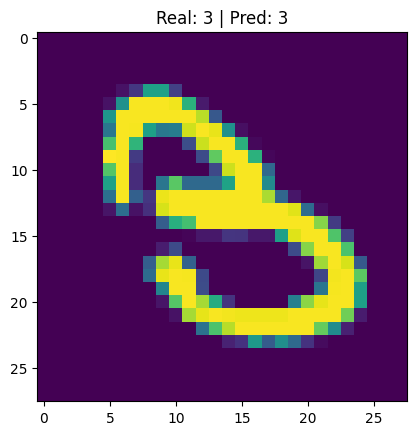

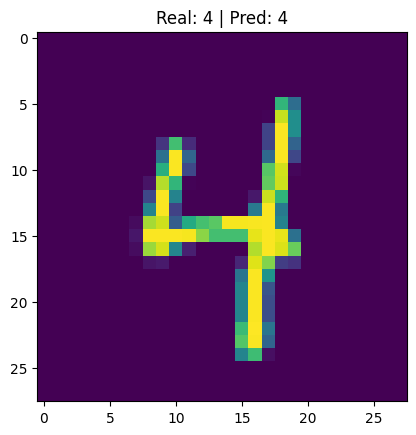

In [20]:
model = CNN(in_channels=1, num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.01)
predictions = pipeline(model, loss_fn, opt, 30)

data_iter = iter(testset)
images, labels = next(data_iter)
for i in range(20):
  img = images[i].numpy().transpose((1, 2, 0))
  plt.imshow(img)
  plt.title(f'Real: {labels[i].item()} | Pred: {predictions[i].item()}')
  plt.show()